

# **Assignment 1: Variational Quantum Circuits for ground state properties of the XXZ model**

### *Author: Pablo Tikas Pueyo*

### Part 1: Exact diagonalization

In [1]:
from tqdm import tqdm
import numpy as np
import torch as pt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.linalg import eigh
from torch.linalg import matrix_exp as expm
import itertools
from functools import reduce

In [2]:
id_local = pt.tensor([[1.0,0],[0,1.0]], dtype=pt.complex128)
sigma_x = pt.tensor([[0,1.0],[1.0,0]], dtype= pt.complex128)
sigma_y = pt.tensor([[0,-1.0j],[1.0j,0]], dtype = pt.complex128)
sigma_z = pt.tensor([[1.0,0.0],[0.0,-1.0]],dtype= pt.complex128)

def tensor_identities(k):
    """
    Creates a tensor prod of k 2x2 identities
    Args: 
        k (int): number of subsystems
    Returns:
        Id (pt.tensor): identity operator acting on the composed Hilbert space  
    """
    identities = [id_local for i in range(k)]
    Id = reduce(pt.kron,identities)
    return Id

def construct_sigma_operator(sigma,L,site):
    """
    Constructs an operator applying sigma to site, and the rest of the sites are unchanged
    Args:
        sigma (pt.tensor): local operator (sigma_x,sigma_y,sigma_z)
        L (int): number of spins
        site (int): site index (0-based)
    Returns: 
        local_operator (pt.tensor): operator acting on site
    """
    operators = [id_local if i!=site else sigma for i in range(L)]
    local_operator = reduce(pt.kron,operators)
    return local_operator


def total_sigma_operator(sigma,L):
    """
    Constructs the total operator for a given sigma
    Args:
        sigma (pt.tensor): operator (sigma_x,sigma_y,sigma_z)
        L (int): number of spins
    Returns: 
        total_operator (pt.tensor): total operator (X,Y,Z)
    """
    total_operator = sum(construct_sigma_operator(sigma,L,i) for i in range(L))
    return total_operator


In [ ]:
#CONSTRUCT HAMILTONIAN AND FIND GS ENERGY

def xxz_hamiltonian(L,delta):
    """
    Construct XXZ hamiltonian for L spins (without external field)
    Args:
        L (int): number of spins
        delta (float): parameter of the model
    Returns:
        H (pt.tensor): Hamiltonian matrix        
    """
    dim = 2**L
    H = pt.zeros((dim,dim))
    
    for i in range(L):
        if L==2 and i==1:
            continue #We avoid doubling the interaction for 2 spins with periodic boundary conditions
        X_i = construct_sigma_operator(sigma_x,L,i)
        X_i_plus_1 = construct_sigma_operator(sigma_x,L,(i+1)%L) #periodic boundary conditions

        Y_i = construct_sigma_operator(sigma_y,L,i)
        Y_i_plus_1 = construct_sigma_operator(sigma_y,L,(i+1)%L)

        Z_i = construct_sigma_operator(sigma_z,L,i)
        Z_i_plus_1 = construct_sigma_operator(sigma_z,L,(i+1)%L)
        
        H = H - (X_i@X_i_plus_1 + Y_i@Y_i_plus_1 + delta*Z_i@Z_i_plus_1)
        
    return H

def get_GS(L,delta):
    """
    Compute ground state of H
    Args: 
        L (int): number of spins
        delta (float): parameter of the model
    Returns:
        psi_GS (pt.tensor): normalized ground state
        E_GS (float): ground state energy
    """
    H = xxz_hamiltonian(L,delta)
    E,P = eigh(H)
    psi_GS = P[:,0]
    psi_GS = psi_GS/pt.norm(psi_GS)
    E_GS = E[0].item().real
    
    return psi_GS,E_GS

L_values = range(2,11)
delta_values = np.linspace(-2,2,9)

data_energies = [[L,delta,get_GS(L,delta)[1]] for L in L_values for delta in delta_values]
df_energies_ED = pd.DataFrame(data_energies,columns=["L","delta","E_GS"])

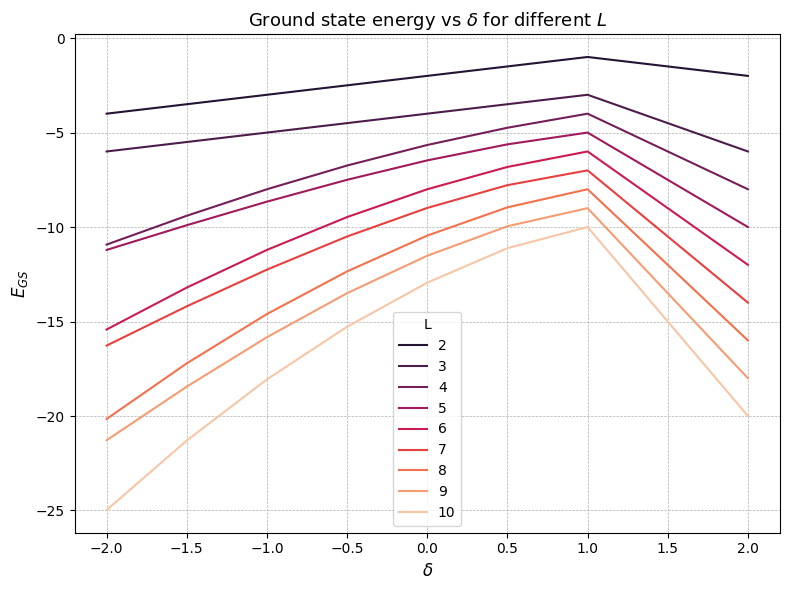

In [4]:
palette = sns.color_palette("rocket", len(L_values))

plt.figure(figsize=(8,6))
sns.lineplot(data=df_energies_ED,x="delta",y="E_GS",hue="L",palette=palette)
plt.xlabel("$\delta$",fontsize=12)
plt.ylabel("$E_{GS}$", fontsize=12)
plt.title("Ground state energy vs $\delta$ for different $L$",fontsize=13)
plt.grid(True,linestyle="--",linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# BIPARTITE ENTANGLEMENT ENTROPY

def construct_density_matrix(state):
    """
    Construct density matrix for a given quantum state.
    
    Args:
        state (pt.tensor): Quantum state (vector).
        
    Returns:
        density_matrix (pt.tensor): Density matrix of the state.
    """
    density_matrix = pt.outer(state, state.conj())
    return density_matrix

def reduced_density_matrix(L, density_matrix):
    """
    Construct the reduced density matrix by tracing out the first half of the qubits.
    
    Args:
        L (int): Total number of qubits.
        density_matrix (pt.tensor): Density matrix of the full system of shape (2**L, 2**L).
        
    Returns:
        reduced_matrix (pt.tensor): Reduced density matrix on subsystem B (the second half).
    """
    L_A = L // 2 # number of qubits to trace out (subsystem A)
    L_B = L - L_A #number of qubits to keep
    
    rho_reshaped = density_matrix.reshape(2**L_A,2**L_B,2**L_A,2**L_B)
    
    # Partial trace over subsystem A
    reduced_rho = pt.einsum("a i a j -> i j", rho_reshaped)
    return reduced_rho

def density_matrix_entropy(density_matrix):
    """
    Computes the von Neumann entropy of a density matrix.
    
    Args:
        density_matrix (pt.tensor): Density matrix of the system.
        
    Returns:
        entropy (pt.tensor): Entropy (as a scalar tensor).
    """
    eigenvalues, _ = eigh(density_matrix)
    eigenvalues = eigenvalues[eigenvalues > 0]
    entropy = -pt.sum(eigenvalues * pt.log2(eigenvalues))
    return entropy

def bipartite_entang_entropy(L, state):
    """
    Compute the bipartite entanglement entropy of a pure state
    by tracing out the first half of the qubits.
    
    Args:
        L (int): Total number of qubits.
        state (pt.tensor): Pure quantum state (vector of dimension 2**L).
        
    Returns:
        entanglement_entropy (float): Bipartite entanglement entropy.
    """
    rho = construct_density_matrix(state)
    reduced_rho = reduced_density_matrix(L, rho)
    entang_entropy = density_matrix_entropy(reduced_rho)
    return entang_entropy.item()

data_entropies = [[L, delta, bipartite_entang_entropy(L, get_GS(L, delta)[0])]for L in L_values for delta in delta_values]
df_entropies_ED = pd.DataFrame(data_entropies, columns=["L", "delta", "entang_entropy"])

    


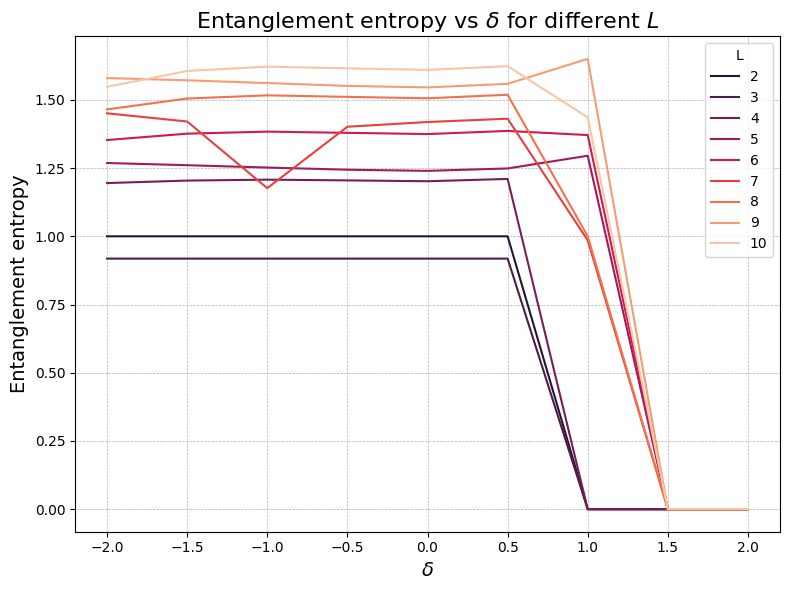

In [6]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df_entropies_ED,x="delta",y="entang_entropy",hue="L",palette=palette)
plt.xlabel("$\delta$",fontsize=14)
plt.ylabel("Entanglement entropy", fontsize=14)
plt.title("Entanglement entropy vs $\delta$ for different $L$",fontsize=16)
plt.grid(True,linestyle="--",linewidth=0.5)
plt.tight_layout()
plt.show()

In [7]:
def get_exp_val_and_var(L,psi):
    """
    Compute the expected values and variances of total operators for a state psi
    Args:
        L (int): number of subsystems
        psi (pt.tensor): quantum state
    Returns:
        exp_vals (list): exp values of X,Y,Z
        variances (list): variances of X,Y,Z
    """
    total_X = total_sigma_operator(sigma_x,L)
    total_Y = total_sigma_operator(sigma_y,L)
    total_Z = total_sigma_operator(sigma_z,L)

    exp_X = pt.vdot(psi,total_X @ psi).item().real
    exp_Y = pt.vdot(psi,total_Y @ psi).item().real
    exp_Z = pt.vdot(psi,total_Z @ psi).item().real

    exp_vals = [exp_X,exp_Y,exp_Z]

    exp_X_sqr = pt.vdot(psi,total_X @ total_X @ psi).item().real
    exp_Y_sqr = pt.vdot(psi,total_Y @ total_Y @ psi).item().real
    exp_Z_sqr = pt.vdot(psi,total_Z @ total_Z @ psi).item().real   

    var_X = exp_X_sqr - exp_X**2
    var_Y = exp_Y_sqr - exp_Y**2
    var_Z = exp_Z_sqr - exp_Z**2

    variances = [var_X,var_Y,var_Z]

    return exp_vals,variances

data_expvals_and_vars = []
for L in L_values:
    for delta in delta_values:
        psi_GS = get_GS(L,delta)[0]
        exp_vals, variances = get_exp_val_and_var(L,psi_GS)
        data_expvals_and_vars.append([L,delta,*exp_vals,*variances])

df_expvals_and_vars_ED = pd.DataFrame(data_expvals_and_vars, columns=["L","delta","exp_X","exp_Y","exp_Z","var_X","var_Y","var_Z"])






Text(0, 0.5, '$(\\Delta Z)^2$')

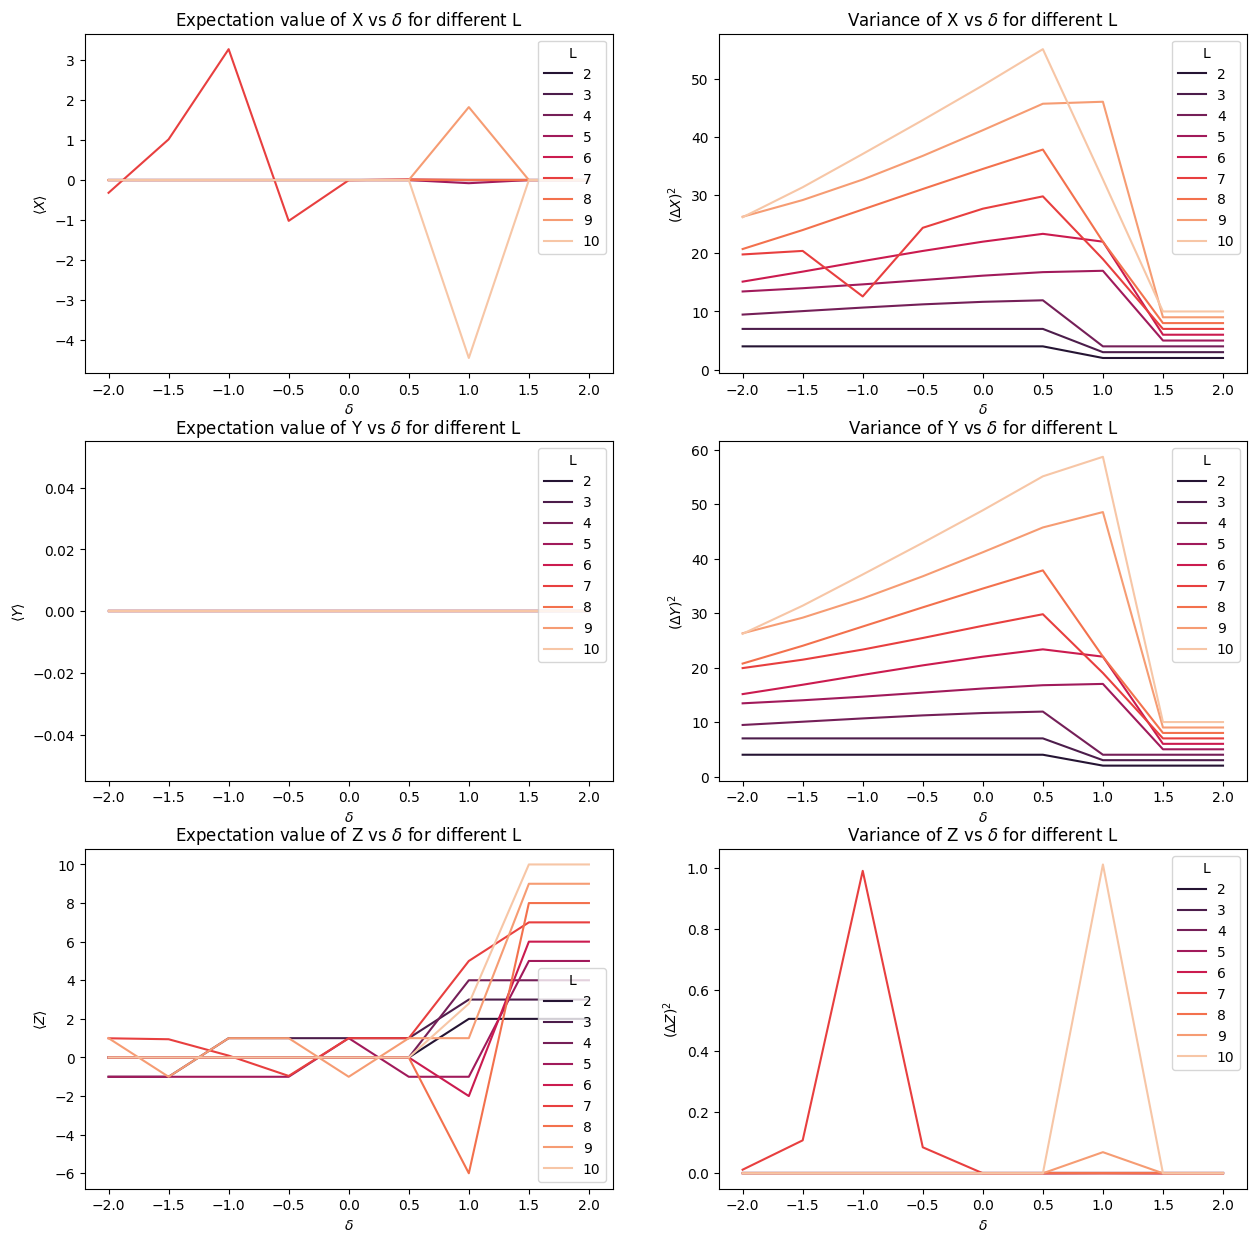

In [8]:
fig, axes = plt.subplots(3,2,figsize=(15,15))

#Plots for X
sns.lineplot(ax=axes[0,0],
             data = df_expvals_and_vars_ED,
             x="delta",
             y="exp_X",
             hue="L",
             palette=palette)
axes[0,0].set_title("Expectation value of X vs $\delta$ for different L")
axes[0,0].set_xlabel("$\delta$")
axes[0,0].set_ylabel(r"$\langle X \rangle$")
sns.lineplot(ax=axes[0,1],
             data = df_expvals_and_vars_ED,
             x="delta",
             y="var_X",
             hue="L",
             palette=palette)
axes[0,1].set_title("Variance of X vs $\delta$ for different L")
axes[0,1].set_xlabel("$\delta$")
axes[0,1].set_ylabel(r"$(\Delta X)^2$")

#Plots for Y
sns.lineplot(ax=axes[1,0],
             data = df_expvals_and_vars_ED,
             x="delta",
             y="exp_Y",
             hue="L",
             palette=palette)
axes[1,0].set_title("Expectation value of Y vs $\delta$ for different L")
axes[1,0].set_xlabel("$\delta$")
axes[1,0].set_ylabel(r"$\langle Y \rangle$")
sns.lineplot(ax=axes[1,1],
             data = df_expvals_and_vars_ED,
             x="delta",
             y="var_Y",
             hue="L",
             palette=palette)
axes[1,1].set_title("Variance of Y vs $\delta$ for different L")
axes[1,1].set_xlabel("$\delta$")
axes[1,1].set_ylabel(r"$(\Delta Y)^2$")

#Plots for Z
sns.lineplot(ax=axes[2,0],
             data = df_expvals_and_vars_ED,
             x="delta",
             y="exp_Z",
             hue="L",
             palette=palette)
axes[2,0].set_title("Expectation value of Z vs $\delta$ for different L")
axes[2,0].set_xlabel("$\delta$")
axes[2,0].set_ylabel(r"$\langle Z \rangle$")
sns.lineplot(ax=axes[2,1],
             data = df_expvals_and_vars_ED,
             x="delta",
             y="var_Z",
             hue="L",
             palette=palette)
axes[2,1].set_title("Variance of Z vs $\delta$ for different L")
axes[2,1].set_xlabel("$\delta$")
axes[2,1].set_ylabel(r"$(\Delta Z)^2$")

### Part 2: Variational Circuits for Ground State search.



In [9]:
#Define gates for variational circuits

def hadamard(L,site):
    """
    Constructs H-gate on specific site
    Args:
        L (int): number of subsystems
        site (int): subsystem to which H is applied
    Returns:
        H (pt.tensor): Hadamard gate acting on site
    """
    local_hadamard = 1/np.sqrt(2)*pt.tensor([[1.0,1.0],[1.0,-1.0]],dtype=pt.complex128)
    operators = [id_local if i!=site else local_hadamard for i in range(L)]
    H = reduce(pt.kron,operators)
    return H

def R_x(theta,L,site):
    """
    Constructs rotation gate about x axis with angle theta on specific site
    Args:
        theta (float): angle of rotation
        L (int): number of subsystems
        site (int): subsystem to which rotation is applied
    Returns:
        Rx (pt.tensor): rotation gate
    """
    local_Rx = expm(-1j*theta/2*sigma_x)
    operators = [id_local if i!=site else local_Rx for i in range(L)]
    Rx = reduce(pt.kron,operators)
    return Rx

def R_y(theta,L,site):
    """
    Constructs rotation gate about y axis with angle theta on specific site
    Args:
        theta (float): angle of rotation
        L (int): number of subsystems
        site (int): subsystem to which rotation is applied
    Returns:
        Rx (pt.tensor): rotation gate
    """
    local_Ry = expm(-1j*theta/2*sigma_y)
    operators = [id_local if i!=site else local_Ry for i in range(L)]
    Ry = reduce(pt.kron,operators)
    return Ry

def R_z(theta,L,site):
    """
    Constructs rotation gate about z axis with angle theta on specific site
    Args:
        theta (float): angle of rotation
        L (int): number of subsystems
        site (int): subsystem to which rotation is applied
    Returns:
        Rx (pt.tensor): rotation gate
    """
    local_Rz = expm(-1j*theta/2*sigma_z)
    operators = [id_local if i!=site else local_Rz for i in range(L)]
    Rz = reduce(pt.kron,operators)
    return Rz

def CNOT(L,control,target):
    """
    Applies CNOT to specified pair (control,target)
    Args:
        L (int): number of subsystems
        control (int): index of control qubit
        target (int): index of target qubit
    Returns:
        CNOT_gate (pt.tensor): CNOT gate acting on composed system
    """

    P_0 = pt.tensor([[1.0,0.0],[0.0,0.0]], dtype=pt.complex128)
    P_1 = pt.tensor([[0.0,0.0],[0.0,1.0]], dtype=pt.complex128)

    operators_0 = [id_local if i!=control else P_0 for i in range(L)]
    operators_1 = [id_local if (i!=control and i!= target) else (P_1 if i==control else sigma_x) for i in range(L) ]

    CNOT_gate = reduce(pt.kron,operators_0) + reduce(pt.kron,operators_1)
    return CNOT_gate 
    
def controlled_Rx(theta,L,control,target):   
    """
    Applies c-Rx to specified pair (control,target)
    Args:
        theta (float): angle of rotation
        L (int): number of subsystems
        control (int): index of control qubit
        target (int): index of target qubit
    Returns:
        cRx (pt.tensor): c-Rx gate acting on composed system
    """
    P_0 = pt.tensor([[1.0,0.0],[0.0,0.0]], dtype=pt.complex128)
    P_1 = pt.tensor([[0.0,0.0],[0.0,1.0]], dtype=pt.complex128)

    local_Rx = expm(-1j*theta/2*sigma_x)

    operators_0 = [id_local if i!=control else P_0 for i in range(L)]
    operators_1 = [id_local if (i!=control and i!= target) else (P_1 if i==control else local_Rx) for i in range(L) ]

    cRx = reduce(pt.kron,operators_0) + reduce(pt.kron,operators_1)
    return cRx

def controlled_Ry(theta,L,control,target):   
    """
    Applies c-Ry to specified pair (control,target)
    Args:
        theta (float): angle of rotation
        L (int): number of subsystems
        control (int): index of control qubit
        target (int): index of target qubit
    Returns:
        cRy (pt.tensor): c-Ry gate acting on composed system
    """
    P_0 = pt.tensor([[1.0,0.0],[0.0,0.0]], dtype=pt.complex128)
    P_1 = pt.tensor([[0.0,0.0],[0.0,1.0]], dtype=pt.complex128)

    local_Ry = expm(-1j*theta/2*sigma_y)

    operators_0 = [id_local if i!=control else P_0 for i in range(L)]
    operators_1 = [id_local if (i!=control and i!= target) else (P_1 if i==control else local_Ry) for i in range(L) ]

    cRy = reduce(pt.kron,operators_0) + reduce(pt.kron,operators_1)
    return cRy  

def controlled_Rz(theta,L,control,target):   
    """
    Applies c-Rz to specified pair (control,target)
    Args:
        theta (float): angle of rotation
        L (int): number of subsystems
        control (int): index of control qubit
        target (int): index of target qubit
    Returns:
        cRz (pt.tensor): c-Rz gate acting on composed system
    """
    P_0 = pt.tensor([[1.0,0.0],[0.0,0.0]], dtype=pt.complex128)
    P_1 = pt.tensor([[0.0,0.0],[0.0,1.0]], dtype=pt.complex128)

    local_Rz = expm(-1j*theta/2*sigma_z)

    operators_0 = [id_local if i!=control else P_0 for i in range(L)]
    operators_1 = [id_local if (i!=control and i!= target) else (P_1 if i==control else local_Rz) for i in range(L) ]

    cRz = reduce(pt.kron,operators_0) + reduce(pt.kron,operators_1)
    return cRz  
    
def ZZ(theta,L,site_1,site_2):
    """
    Applies ZZ to specified pair (site_1,site_2)
    Args:
        theta (float): angle of rotation
        L (int): number of subsystems
        site_1 (int): index of first qubit
        site_2 (int): index of second qubit
    Returns:
        ZZ_gate (pt.tensor): ZZ-gate gate acting on composed system
    """
    sigma_z_site_1 = construct_sigma_operator(sigma_z,L,site_1)
    sigma_z_site_2 = construct_sigma_operator(sigma_z,L,site_2)

    ZZ_gate = expm(-1j*theta/2*sigma_z_site_1@sigma_z_site_2)
    return ZZ_gate

def XX(theta,L,site_1,site_2):
    """
    Applies XX to specified pair (site_1,site_2)
    Args:
        theta (float): angle of rotation
        L (int): number of subsystems
        site_1 (int): index of first qubit
        site_2 (int): index of second qubit
    Returns:
        XX_gate (pt.tensor): XX-gate gate acting on composed system
    """
    sigma_x_site_1 = construct_sigma_operator(sigma_x,L,site_1)
    sigma_x_site_2 = construct_sigma_operator(sigma_x,L,site_2)

    XX_gate = expm(-1j*theta/2*sigma_x_site_1@sigma_x_site_2)
    return XX_gate

def YY(theta,L,site_1,site_2):
    """
    Applies YY to specified pair (site_1,site_2)
    Args:
        theta (float): angle of rotation
        L (int): number of subsystems
        site_1 (int): index of first qubit
        site_2 (int): index of second qubit
    Returns:
        YY_gate (pt.tensor): YY-gate gate acting on composed system
    """
    sigma_y_site_1 = construct_sigma_operator(sigma_y,L,site_1)
    sigma_y_site_2 = construct_sigma_operator(sigma_y,L,site_2)

    YY_gate = expm(-1j*theta/2*sigma_y_site_1@sigma_y_site_2)
    return YY_gate


In [10]:
def compute_fidelity(psi,phi):
    """
    Description: Compute fidelity between two pure quantum states
    Args:
        psi (pt.tensor): quantum state
        phi (pt.tensor): quantum state
    Returns:
        F (float): fidelity
    """
    F = pt.abs(pt.vdot(psi,phi)).item().real
    return F

In [11]:
#ANSATZ 1: CNOTs
def ansatz_1(theta,L,p):
    """
    Description: Variational Quantum Circuit ansatz for GS with only CNOTs as entangling gates
    Args:
        theta (pt.tensor): Parameters of the circuit
        L (int): number of subsystems
        p (int): number of layers of the circuit
    Returns:
        circuit_state (pt.tensor): output state of the circuit
    """
    dim = 2**L
    circuit_state = pt.zeros(dim,dtype=pt.complex128)
    circuit_state[dim-1] = 1.0 #State corresponding to all spins down

    if len(theta) != 2*p*L:
        raise ValueError("Number of parameters must be equal to ", 2*p*L, ".")
    
    #Layer of Hadamards
    for i in range(L):
        circuit_state = hadamard(L,i) @ circuit_state

    for layer in range(p):
        #Single-qubit rotations    
        for i in range(L):
            circuit_state = R_z(theta[2*i+2*L*layer],L,i) @ circuit_state
            circuit_state = R_y(theta[2*i+1+2*L*layer],L,i) @ circuit_state
        #CNOTs
        for i in range(L):
            circuit_state = CNOT(L,i,(i+1) % L) @ circuit_state

    return circuit_state

#ANSATZ 2: Controlled Rotations
def ansatz_2(theta,L,p):
    """
    Description: Variational Quantum Circuit ansatz for GS with only CNOTs as entangling gates
    Args:
        theta (pt.tensor): Parameters of the circuit
        L (int): number of subsystems
        p (int): depth of the system
    Returns:
        circuit_state (pt.tensor): output state of the circuit
    """
    dim = 2**L
    circuit_state = pt.zeros(dim,dtype=pt.complex128)
    circuit_state[dim-1] = 1.0 #State corresponding to all spins down

    if len(theta) != 3*p*L:
        raise ValueError("Number of parameters must be equal to ", 3*p*L, ".")
    
    #Layer of Hadamard
    for i in range(L):
        circuit_state = hadamard(L,i) @ circuit_state
    
    for layer in range(p):
    #Layer of rotations
        for i in range(L):
            circuit_state = R_z(theta[2*i+3*layer*L],L,i) @ circuit_state
            circuit_state = R_y(theta[2*i+1+3*layer*L],L,i) @ circuit_state
        #Layer of controlled rotations
        for i in range(L):
            circuit_state = controlled_Rx(theta[i+2*L+3*layer*L],L,i,(i+1) % L) @ circuit_state
           
    return circuit_state

#ANSATZ 3: HVA
def ansatz_3(theta,L,p):
    """
    Description: Hamiltonian Variational Ansatz circuit
    Args:
        theta (pt.tensor): Parameters of the circuit
        L (int): number of subsystems
        p (int): depth of the circuit
    Returns:
        circuit_state (pt.tensor): output state of the circuit
    """
    dim = 2**L
    circuit_state = pt.zeros(dim,dtype=pt.complex128)
    circuit_state[dim-1] = 1.0 #State corresponding to all spins down

    if len(theta) != 5*p*L:
        raise ValueError("Number of parameters must be equal to ", 5*p*L, ".")
    
    #Layer of Hadamards
    for i in range(L):
        circuit_state = hadamard(L,i)@circuit_state
    
        
    for layer in range(p):
        #Layer of single-qubit gates
        for i in range(L):
            circuit_state = R_z(theta[2*i+5*layer*L],L,i) @ circuit_state
            circuit_state = R_y(theta[2*i+1+5*layer*L],L,i) @ circuit_state
        #Layer of Pauli-Pauli gates
        for i in range(L):
            circuit_state = ZZ(theta[i+2*L+5*layer*L],L,i,(i+1) % L) @ circuit_state
        for i in range(L):
            circuit_state = YY(theta[i+3*L+5*layer*L],L,i,(i+1) % L) @ circuit_state
        for i in range(L):
            circuit_state = XX(theta[i+4*L+5*layer*L],L,i,(i+1) % L) @ circuit_state
        
    
    return circuit_state


In [12]:
def get_circuit_GS(circuit,p,theta,L,delta):
    """
    Description: Get the GS quantum state and energy for a set of parameters' values
    Args:
        circuit (func): quantum circuit
        p (int): depth of the circuit
        theta (np.array): Parameters of the circuit
        L (int): number of subsystems
        delta (float): parameter of the Hamiltonian
    Returns:
        circuit_state: quantum state of GS
        E (float): energy for the set of values theta
    """
    circuit_state = circuit(theta,L,p)
    H = xxz_hamiltonian(L,delta)
    E = pt.vdot(circuit_state,H @ circuit_state)
    return circuit_state,E.real
  

In [13]:
L = 5 #system size
max_layers=3
p_values = [max_layers]
delta_values = np.linspace(-2,2,9)

data_fidelity_1 = []
data_fidelity_2 = []
data_fidelity_3 = []

data_energies_1 = []
data_energies_2 = []
data_energies_3 = []

data_entropy_1 = []
data_entropy_2 = []
data_entropy_3 = []

data_expvals_and_vars_1 = []
data_expvals_and_vars_2 = []
data_expvals_and_vars_3 = []

for p in p_values:
    #Optimization for circuit 1
    for delta in tqdm(delta_values):
        theta = pt.full((2*p*L,), np.pi/(2*L), requires_grad=True)
        optimizer = pt.optim.Adam([theta],lr=0.1)
        for i in range(200):
            _, loss = get_circuit_GS(ansatz_1,p,theta,L,delta)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with pt.no_grad():
                theta.clamp_(min=-np.pi/L, max=np.pi/L)
        
        final_circuit_state,final_E = get_circuit_GS(ansatz_1,p,theta,L,delta)
        real_state,real_E = get_GS(L,delta)

        data_energies_1.append([p,delta,final_E.item()])
    
        fidelity = compute_fidelity(real_state,final_circuit_state)
        data_fidelity_1.append([p,delta,fidelity])

        entropy = bipartite_entang_entropy(L,final_circuit_state)
        data_entropy_1.append([p,delta,entropy])

        exp_vals, variances = get_exp_val_and_var(L,final_circuit_state)
        data_expvals_and_vars_1.append([p,delta,*exp_vals,*variances])
        

    #Optimization for circuit 2
    for delta in tqdm(delta_values):
        theta = pt.full((3*p*L,), np.pi/(2*L), requires_grad=True)
        optimizer = pt.optim.Adam([theta],lr=0.1)
        for i in range(200):
            _, loss = get_circuit_GS(ansatz_2,p,theta,L,delta)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with pt.no_grad():
                theta.clamp_(min=-np.pi/L, max=np.pi/L)
        
        final_circuit_state,final_E = get_circuit_GS(ansatz_2,p,theta,L,delta)
        real_state,real_E = get_GS(L,delta)
    
        data_energies_2.append([p,delta,final_E.item()])
    
        fidelity = compute_fidelity(real_state,final_circuit_state)
        data_fidelity_2.append([p,delta,fidelity])

        entropy = bipartite_entang_entropy(L,final_circuit_state)
        data_entropy_2.append([p,delta,entropy])

        exp_vals, variances = get_exp_val_and_var(L,final_circuit_state)
        data_expvals_and_vars_2.append([p,delta,*exp_vals,*variances])

    #Optimization for circuit 3
    for delta in tqdm(delta_values):
        theta = pt.full((5*p*L,), np.pi/(2*L), requires_grad=True)
        optimizer = pt.optim.Adam([theta],lr=0.1)
        for i in range(200):
            _, loss = get_circuit_GS(ansatz_3,p,theta,L,delta)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with pt.no_grad():
                theta.clamp_(min=-np.pi/L, max=np.pi/L)
        
        final_circuit_state,final_E = get_circuit_GS(ansatz_3,p,theta,L,delta)
        real_state,real_E = get_GS(L,delta)
    
        data_energies_3.append([p,delta,final_E.item()])
    
        fidelity = compute_fidelity(real_state,final_circuit_state)
        data_fidelity_3.append([p,delta,fidelity])

        entropy = bipartite_entang_entropy(L,final_circuit_state)
        data_entropy_3.append([p,delta,entropy])

        exp_vals, variances = get_exp_val_and_var(L,final_circuit_state)
        data_expvals_and_vars_3.append([p,delta,*exp_vals,*variances])


100%|██████████| 9/9 [07:57<00:00, 53.00s/it]


In [14]:
df_energies_1 = pd.DataFrame(data_energies_1,columns=["p","delta","energy"])
df_energies_2 = pd.DataFrame(data_energies_2,columns=["p","delta","energy"])
df_energies_3 = pd.DataFrame(data_energies_3,columns=["p","delta","energy"])

df_fidelity_1 = pd.DataFrame(data_fidelity_1,columns=["p","delta","fidelity"])
df_fidelity_2 = pd.DataFrame(data_fidelity_2,columns=["p","delta","fidelity"])
df_fidelity_3 = pd.DataFrame(data_fidelity_3,columns=["p","delta","fidelity"])

df_entropy_1 = pd.DataFrame(data_entropy_1,columns=["p","delta","entropy"])
df_entropy_2 = pd.DataFrame(data_entropy_2,columns=["p","delta","entropy"])
df_entropy_3 = pd.DataFrame(data_entropy_3,columns=["p","delta","entropy"])

df_expvals_and_vars_1 = pd.DataFrame(data_expvals_and_vars_1,columns=["p","delta","exp_X","exp_Y","exp_Z","var_X","var_Y","var_Z"])
df_expvals_and_vars_2 = pd.DataFrame(data_expvals_and_vars_2,columns=["p","delta","exp_X","exp_Y","exp_Z","var_X","var_Y","var_Z"])
df_expvals_and_vars_3 = pd.DataFrame(data_expvals_and_vars_3,columns=["p","delta","exp_X","exp_Y","exp_Z","var_X","var_Y","var_Z"])

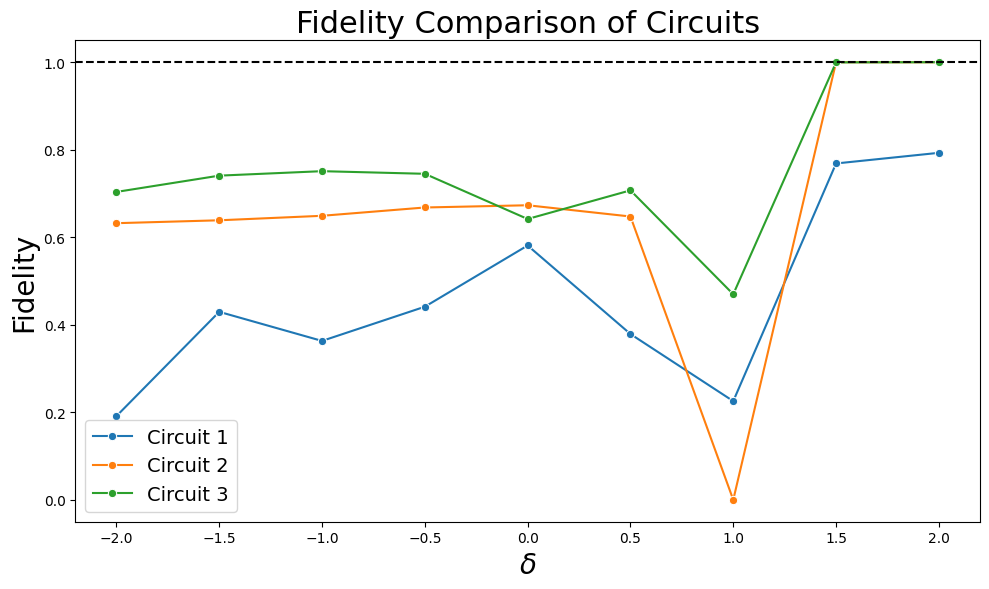

In [15]:
plt.figure(figsize=(10, 6))


sns.lineplot(data=df_fidelity_1, x="delta", y="fidelity", marker="o", label="Circuit 1")
sns.lineplot(data=df_fidelity_2, x="delta", y="fidelity", marker="o", label="Circuit 2")
sns.lineplot(data=df_fidelity_3, x="delta", y="fidelity", marker="o", label="Circuit 3")

plt.axhline(y=1.0, color="black", linestyle="dashed", linewidth=1.5)


plt.title("Fidelity Comparison of Circuits", fontsize=22)
plt.xlabel("$\delta$", fontsize=20)
plt.ylabel("Fidelity", fontsize=20)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


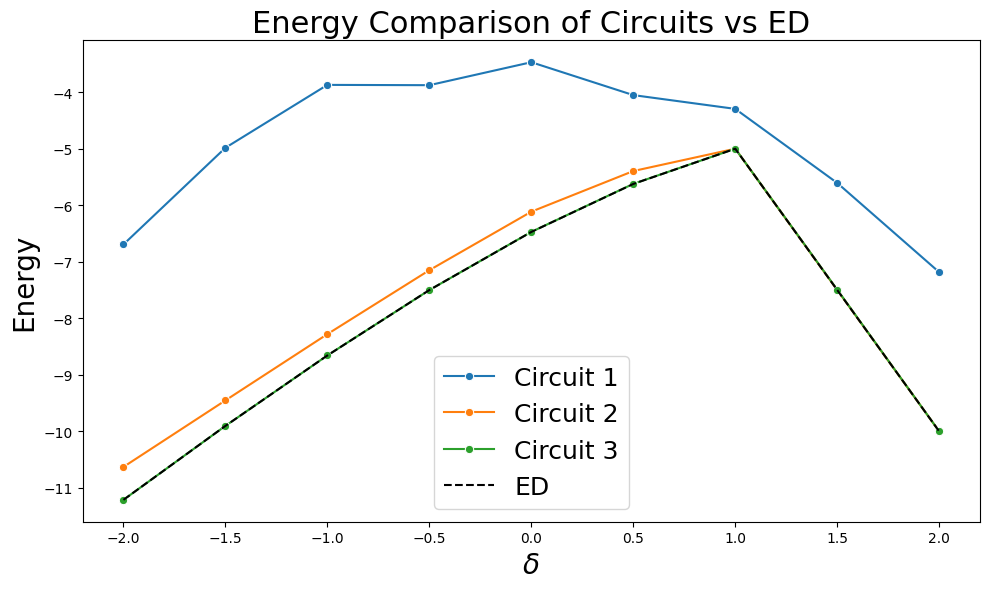

In [16]:
# Keep only values of max depth circuits
df_energies_1 = df_energies_1[df_energies_1["p"] == max_layers]
df_energies_2 = df_energies_2[df_energies_2["p"] == max_layers]
df_energies_3 = df_energies_3[df_energies_3["p"] == max_layers]

df_energies_ED_ref = df_energies_ED[df_energies_ED["L"] == L]

df_energies_1.sort_values(by=["delta"], inplace=True)
df_energies_2.sort_values(by=["delta"], inplace=True)
df_energies_3.sort_values(by=["delta"], inplace=True)

plt.figure(figsize=(10, 6))

sns.lineplot(data=df_energies_1, x="delta", y="energy", marker="o", label="Circuit 1")
sns.lineplot(data=df_energies_2, x="delta", y="energy", marker="o", label="Circuit 2")
sns.lineplot(data=df_energies_3, x="delta", y="energy", marker="o", label="Circuit 3")
sns.lineplot(data=df_energies_ED_ref, x="delta", y="E_GS", linestyle="dashed", label="ED", color="black")

plt.title("Energy Comparison of Circuits vs ED", fontsize=22)
plt.xlabel("$\delta$", fontsize=20)
plt.ylabel("Energy", fontsize=20)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()


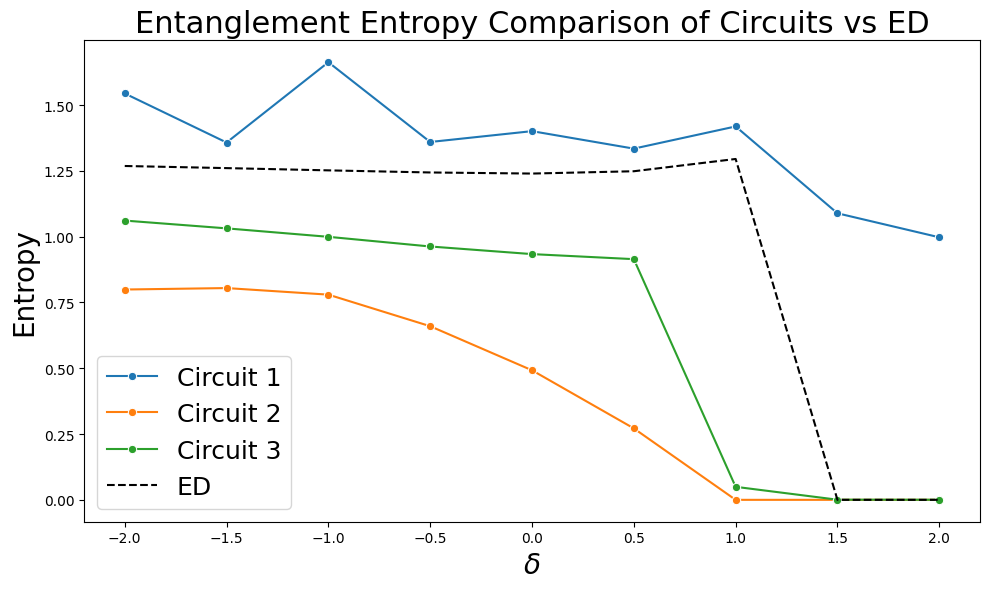

In [17]:
df_entropy_1 = df_entropy_1[df_entropy_1["p"] == max_layers]
df_entropy_2 = df_entropy_2[df_entropy_2["p"] == max_layers]
df_entropy_3 = df_entropy_3[df_entropy_3["p"] == max_layers]

df_entropy_ED_ref = df_entropies_ED[df_entropies_ED["L"] == L]

df_entropy_1.sort_values(by=["delta"], inplace=True)
df_entropy_2.sort_values(by=["delta"], inplace=True)
df_entropy_3.sort_values(by=["delta"], inplace=True)

plt.figure(figsize=(10, 6))

sns.lineplot(data=df_entropy_1, x="delta", y="entropy", marker="o", label="Circuit 1")
sns.lineplot(data=df_entropy_2, x="delta", y="entropy", marker="o", label="Circuit 2")
sns.lineplot(data=df_entropy_3, x="delta", y="entropy", marker="o", label="Circuit 3")
sns.lineplot(data=df_entropy_ED_ref, x="delta", y="entang_entropy", linestyle="dashed", label="ED", color="black")

plt.title("Entanglement Entropy Comparison of Circuits vs ED", fontsize=22)
plt.xlabel("$\delta$", fontsize=20)
plt.ylabel("Entropy", fontsize=20)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()


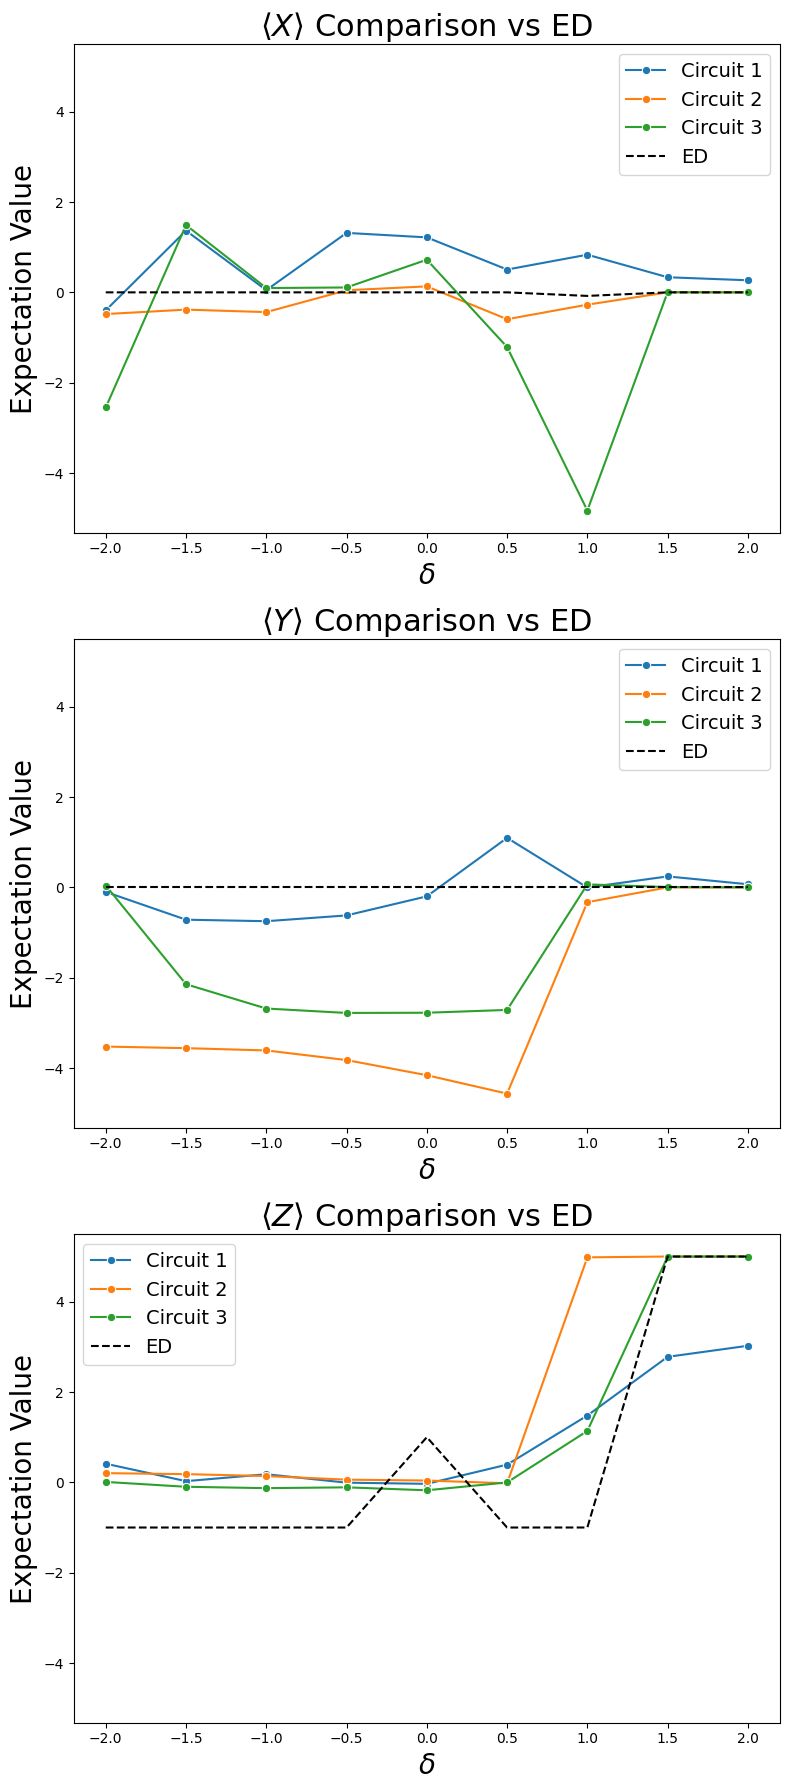

In [29]:
# Filter data for the selected number of layers
df_expvals_and_vars_1 = df_expvals_and_vars_1[df_expvals_and_vars_1["p"] == max_layers]
df_expvals_and_vars_2 = df_expvals_and_vars_2[df_expvals_and_vars_2["p"] == max_layers]
df_expvals_and_vars_3 = df_expvals_and_vars_3[df_expvals_and_vars_3["p"] == max_layers]

df_expvals_and_vars_ED_ref = df_expvals_and_vars_ED[df_expvals_and_vars_ED["L"] == L]

df_expvals_and_vars_1.sort_values(by=["delta"], inplace=True)
df_expvals_and_vars_2.sort_values(by=["delta"], inplace=True)
df_expvals_and_vars_3.sort_values(by=["delta"], inplace=True)

fig, axs = plt.subplots(3, 1, figsize=(8, 18), sharey=True)
axs = axs.flatten()

# Define expectation values and labels
expectation_values = ["exp_X", "exp_Y", "exp_Z"]
exp_labels = [r"$\langle X \rangle$", r"$\langle Y \rangle$", r"$\langle Z \rangle$"]
circuit_dfs = [df_expvals_and_vars_1, df_expvals_and_vars_2, df_expvals_and_vars_3]
circuit_labels = ["Circuit 1", "Circuit 2", "Circuit 3"]
colors = ["tab:blue", "tab:orange", "tab:green"]  # Custom colors for circuits

# Loop over expectation values and create separate subplots
for i, (exp_val, exp_label) in enumerate(zip(expectation_values, exp_labels)):
    ax = axs[i]
    
    # Plot all circuits for the current expectation value
    for df_circuit, label, color in zip(circuit_dfs, circuit_labels, colors):
        sns.lineplot(
            data=df_circuit,
            x="delta",
            y=exp_val,
            marker="o",
            label=label,
            color=color,
            ax=ax
        )
    
    # Plot the ED reference in **black dashed line**
    sns.lineplot(
        data=df_expvals_and_vars_ED_ref,
        x="delta",
        y=exp_val,
        linestyle="dashed",
        color="black",
        label="ED",
        ax=ax
    )

    ax.set_title(f"{exp_label} Comparison vs ED", fontsize=22)
    ax.set_xlabel("$\delta$", fontsize=20)
    ax.set_ylabel("Expectation Value", fontsize=20)
    ax.legend(fontsize=14)

plt.tight_layout()
plt.show()


### 3. Time-evolution

In [19]:
#Construct initial state
plus_state = 1/np.sqrt(2)*pt.tensor([1.0,1.0], dtype=complex)
state = [plus_state for _ in range(L)]
initial_state = reduce(pt.kron,state)
#Define time
t_values = np.linspace(0,4*np.pi,10)

#Exact time-evolution
def exact_time_evolution(L,delta,t_i):
    """
    Compute exact evolved state at time t_i
    Args:
        L (int): system size
        delta (float): anisotropy parameter of the XXZ model
        t_i (float): time of evolved state
    Returns:
        evolved_state (pt.tensor): evolved state at time t_i
    """
    evolved_state = expm(-1j*t_i*xxz_hamiltonian(L,delta)) @ initial_state
    return evolved_state




In [20]:
p = max_layers
delta_values = np.linspace(-2,2,4)

def get_fidelity(circuit,theta,L,delta,t_i):
    """
    Description: Get the fidelity with exact evolved state at t_i
    Args:
        circuit (func): quantum circuit
        theta (np.array): Parameters of the circuit
        L (int): number of subsystems
        delta (float): parameter of the Hamiltonian
        t_i (float): time
    Returns:
        fidelity: fidelity with exact evolved state
    """
    circuit_state = circuit(theta,L,p)
    exactly_evolved_state = exact_time_evolution(L,delta,t_i)
    fidelity = pt.abs(pt.vdot(circuit_state,exactly_evolved_state))**2
    return fidelity

#Optimization using same initialization as before

TE_fidelities_1 = []
for delta in tqdm(delta_values):
    for t_i in t_values:
        theta = pt.full((2*p*L,), np.pi/(2*L), requires_grad=True)
        optimizer = pt.optim.Adam([theta],lr=0.1)
        for i in range(200):
            loss = 1.0 - get_fidelity(ansatz_1,theta,L,delta,t_i)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with pt.no_grad():
                theta.clamp_(min=-np.pi/L, max=np.pi/L)
        final_fidelity = get_fidelity(ansatz_1,theta,L,delta,t_i).item()
        TE_fidelities_1.append([delta,t_i,final_fidelity])

TE_fidelities_2 = []
for delta in tqdm(delta_values):
    for t_i in t_values:
        theta = pt.full((3*p*L,), np.pi/(2*L), requires_grad=True)
        optimizer = pt.optim.Adam([theta],lr=0.1)
        for i in range(200):
            loss = 1.0 -get_fidelity(ansatz_2,theta,L,delta,t_i)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with pt.no_grad():
                theta.clamp_(min=-np.pi/L, max=np.pi/L)
        final_fidelity = get_fidelity(ansatz_2,theta,L,delta,t_i).item()
        TE_fidelities_2.append([delta,t_i,final_fidelity])

TE_fidelities_3 = []
for delta in tqdm(delta_values):
    for t_i in t_values:
        theta = pt.full((5*p*L,), np.pi/(2*L), requires_grad=True)
        optimizer = pt.optim.Adam([theta],lr=0.1)
        for i in range(200):
            loss = 1.0 - get_fidelity(ansatz_3,theta,L,delta,t_i)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with pt.no_grad():
                theta.clamp_(min=-np.pi/L, max=np.pi/L)
        final_fidelity = get_fidelity(ansatz_3,theta,L,delta,t_i).item()
        TE_fidelities_3.append([delta,t_i,final_fidelity])

100%|██████████| 4/4 [35:36<00:00, 534.16s/it]


In [21]:
df_TE_fidelities_1 = pd.DataFrame(TE_fidelities_1,columns=["delta","t_i","fidelity"])
df_TE_fidelities_2 = pd.DataFrame(TE_fidelities_2,columns=["delta","t_i","fidelity"])
df_TE_fidelities_3 = pd.DataFrame(TE_fidelities_3,columns=["delta","t_i","fidelity"])

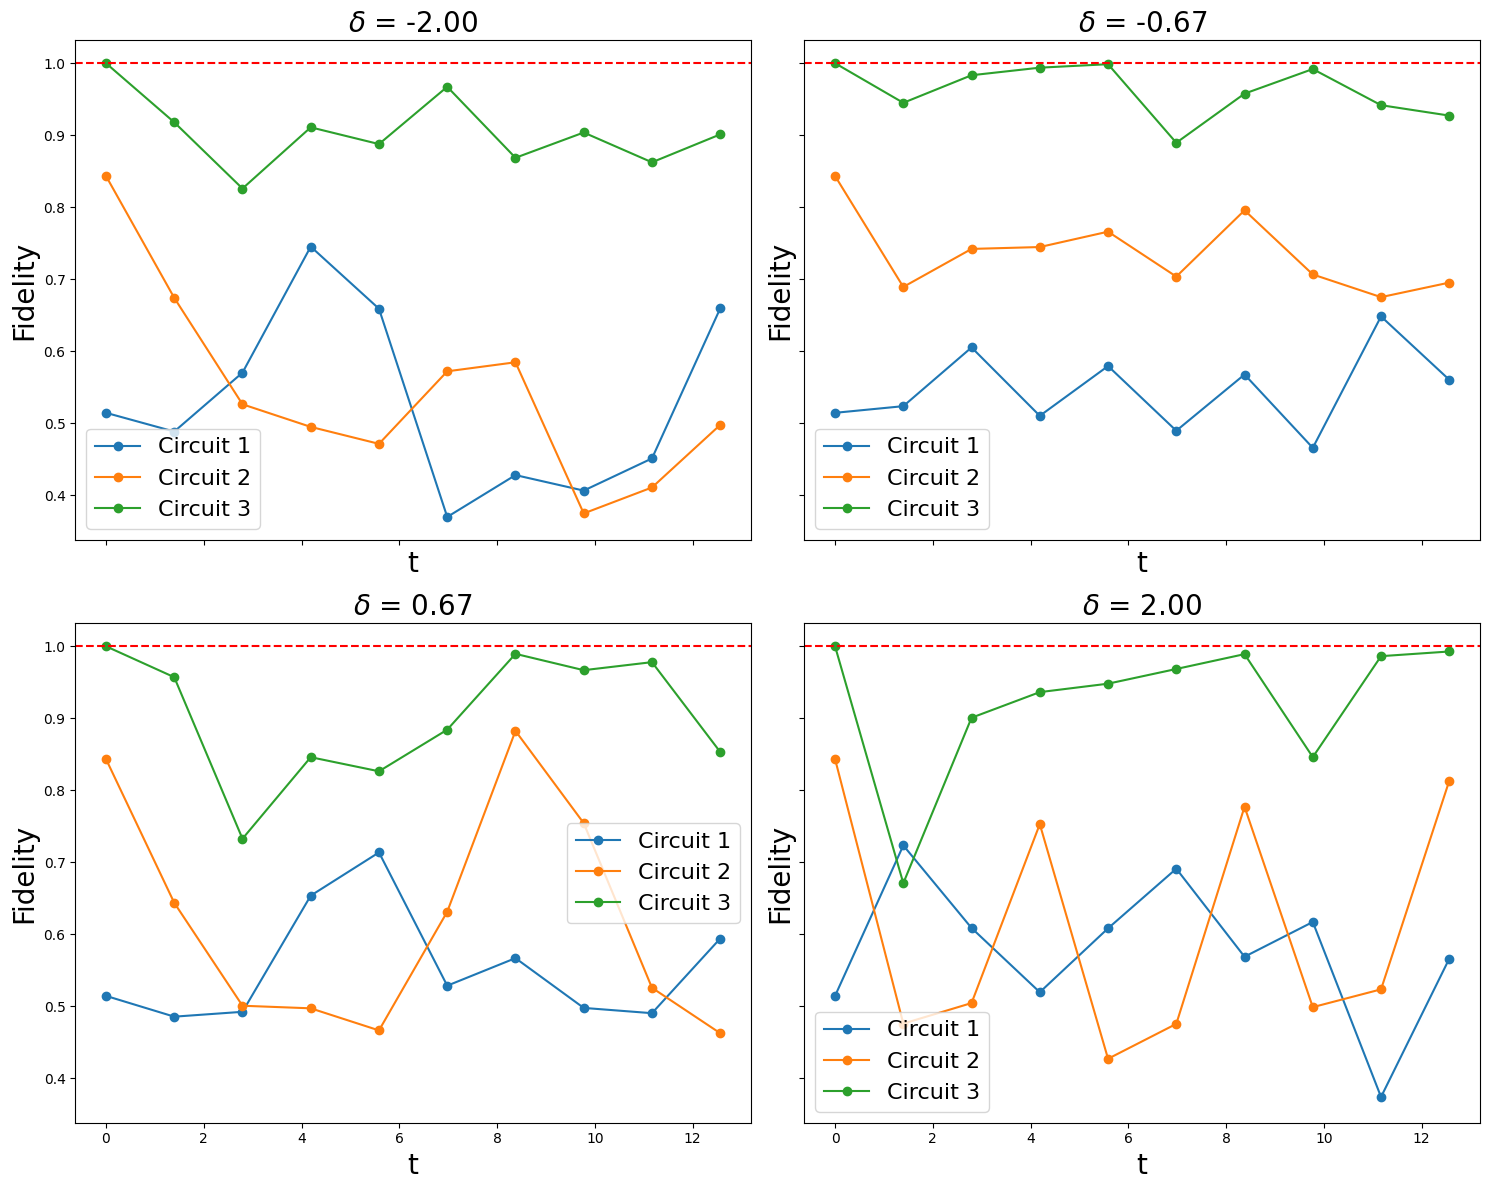

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
axs = axs.flatten()

for i, delta in enumerate(delta_values):
    ax = axs[i]
    # Filter the DataFrames for the current delta value
    df1 = df_TE_fidelities_1[df_TE_fidelities_1["delta"] == delta]
    df2 = df_TE_fidelities_2[df_TE_fidelities_2["delta"] == delta]
    df3 = df_TE_fidelities_3[df_TE_fidelities_3["delta"] == delta]
    
    # Plot fidelity vs t_i for each circuit
    ax.plot(df1["t_i"], df1["fidelity"], marker='o', label='Circuit 1')
    ax.plot(df2["t_i"], df2["fidelity"], marker='o', label='Circuit 2')
    ax.plot(df3["t_i"], df3["fidelity"], marker='o', label='Circuit 3')

    # Add black dashed line at Fidelity = 1.0
    ax.axhline(y=1.0, color="red", linestyle="dashed", linewidth=1.5)

    ax.set_title(f"$\delta$ = {delta:.2f}", fontsize=20)
    ax.set_xlabel("t", fontsize=20)
    ax.set_ylabel("Fidelity", fontsize=20)
    ax.legend(fontsize=16)

fig.tight_layout()
plt.show()


In [23]:
#Optimization using initialization from previous time step

TE_fidelities_1 = []
for delta in tqdm(delta_values):
    theta = pt.full((2*p*L,), np.pi/(2*L), requires_grad=True)
    for t_i in t_values:
        theta = theta
        optimizer = pt.optim.Adam([theta],lr=0.1)
        for i in range(200):
            loss = 1.0 - get_fidelity(ansatz_1,theta,L,delta,t_i)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with pt.no_grad():
                theta.clamp_(min=-np.pi/L, max=np.pi/L)
        final_fidelity = get_fidelity(ansatz_1,theta,L,delta,t_i).item()
        TE_fidelities_1.append([delta,t_i,final_fidelity])

TE_fidelities_2 = []
for delta in tqdm(delta_values):
    theta = pt.full((3*p*L,), np.pi/(2*L), requires_grad=True)
    for t_i in t_values:
        theta = theta
        optimizer = pt.optim.Adam([theta],lr=0.1)
        for i in range(200):
            loss = 1.0 -get_fidelity(ansatz_2,theta,L,delta,t_i)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with pt.no_grad():
                theta.clamp_(min=-np.pi/L, max=np.pi/L)
        final_fidelity = get_fidelity(ansatz_2,theta,L,delta,t_i).item()
        TE_fidelities_2.append([delta,t_i,final_fidelity])

TE_fidelities_3 = []
for delta in tqdm(delta_values):
    theta = pt.full((5*p*L,), np.pi/(2*L), requires_grad=True)
    for t_i in t_values:
        theta = theta
        optimizer = pt.optim.Adam([theta],lr=0.1)
        for i in range(200):
            loss = 1.0 - get_fidelity(ansatz_3,theta,L,delta,t_i)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            with pt.no_grad():
                theta.clamp_(min=-np.pi/L, max=np.pi/L)
        final_fidelity = get_fidelity(ansatz_3,theta,L,delta,t_i).item()
        TE_fidelities_3.append([delta,t_i,final_fidelity])

100%|██████████| 4/4 [22:45<00:00, 341.29s/it]


In [24]:
df_TE_fidelities_1 = pd.DataFrame(TE_fidelities_1,columns=["delta","t_i","fidelity"])
df_TE_fidelities_2 = pd.DataFrame(TE_fidelities_2,columns=["delta","t_i","fidelity"])
df_TE_fidelities_3 = pd.DataFrame(TE_fidelities_3,columns=["delta","t_i","fidelity"])

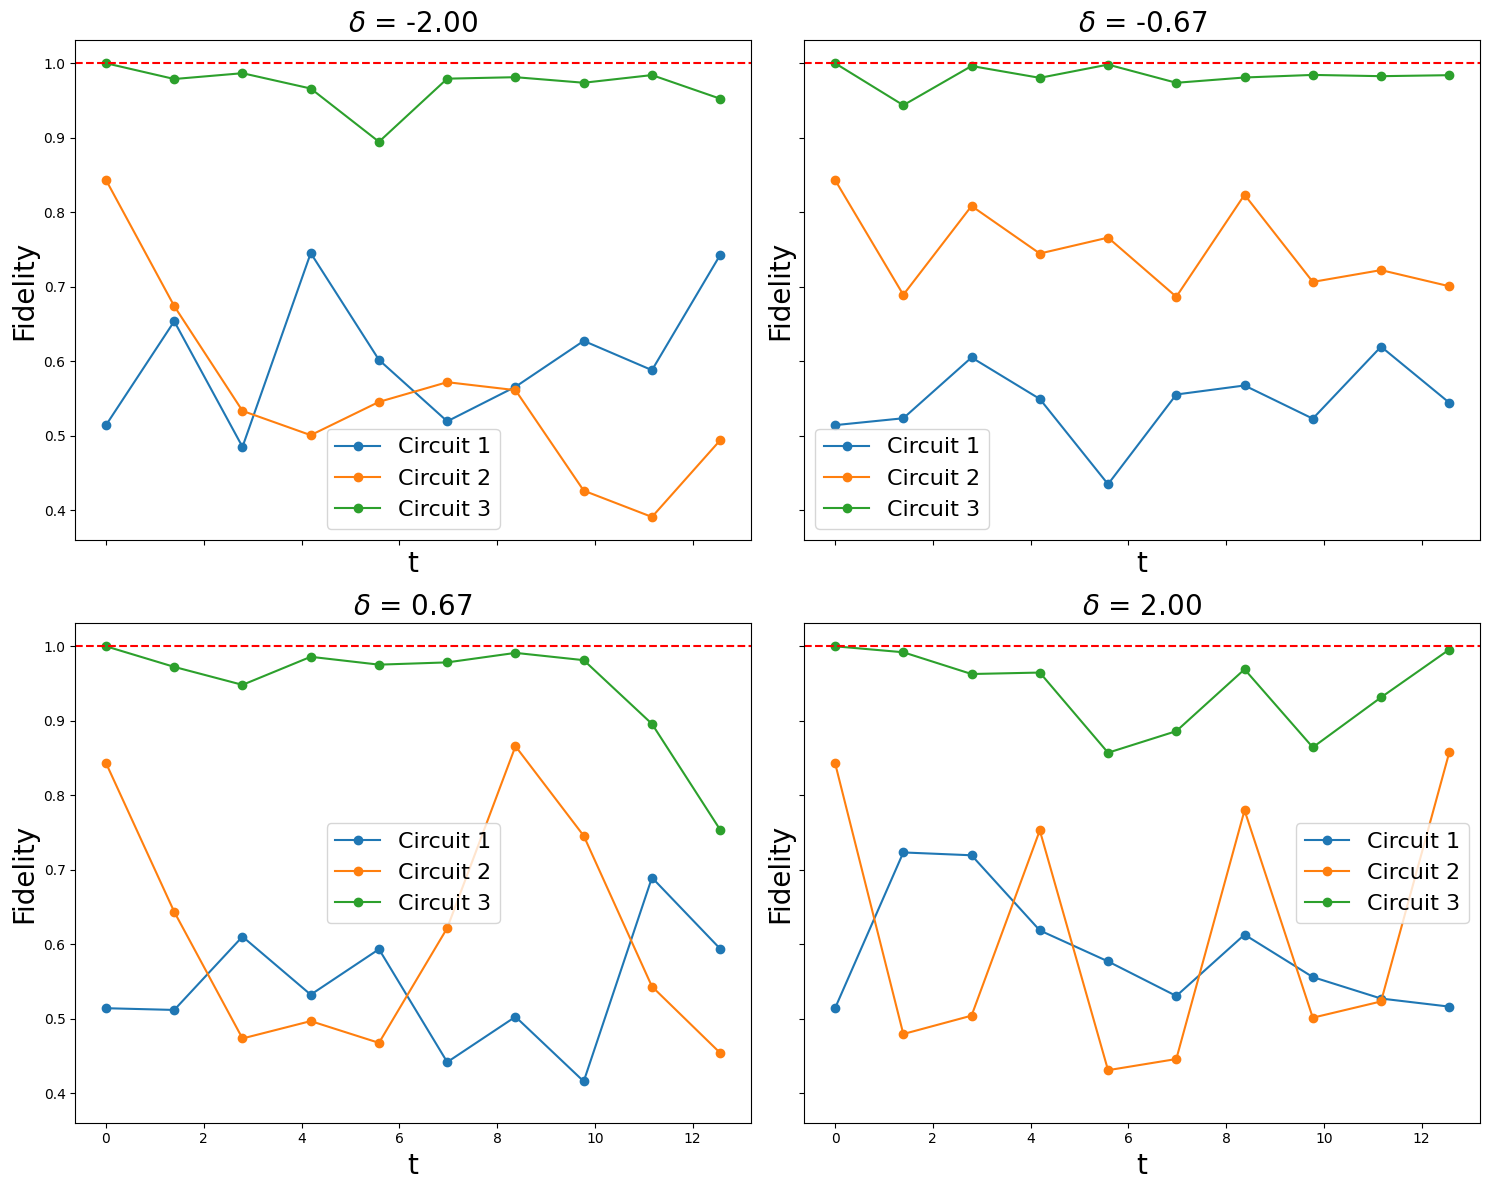

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12), sharex=True, sharey=True)
axs = axs.flatten()

for i, delta in enumerate(delta_values):
    ax = axs[i]
    # Filter the DataFrames for the current delta value
    df1 = df_TE_fidelities_1[df_TE_fidelities_1["delta"] == delta]
    df2 = df_TE_fidelities_2[df_TE_fidelities_2["delta"] == delta]
    df3 = df_TE_fidelities_3[df_TE_fidelities_3["delta"] == delta]
    
    # Plot fidelity vs t_i for each circuit
    ax.plot(df1["t_i"], df1["fidelity"], marker='o', label='Circuit 1')
    ax.plot(df2["t_i"], df2["fidelity"], marker='o', label='Circuit 2')
    ax.plot(df3["t_i"], df3["fidelity"], marker='o', label='Circuit 3')

    # Add black dashed line at Fidelity = 1.0
    ax.axhline(y=1.0, color="red", linestyle="dashed", linewidth=1.5)

    ax.set_title(f"$\delta$ = {delta:.2f}", fontsize=20)
    ax.set_xlabel("t", fontsize=20)
    ax.set_ylabel("Fidelity", fontsize=20)
    ax.legend(fontsize=16)

fig.tight_layout()
plt.show()
